In [ ]:
# NOTE: YOU SHOULD ONLY NEED TO RUN THIS STEP THE FIRST TIME IN A SESSION
# get the data from github and unzip
# The term "wget" stands for "World Wide Web get." It's a command-line utility for downloading files from the internet.
!curl -O https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
!unzip -q speechImageData.zip

# 1. Preprocessing

# 1.1 Orignal data processing

In [9]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData - Copy/TrainData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=128,
    image_size=(98, 50)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData - Copy/ValData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=128,
    image_size=(98, 50)
)

Found 2001 files belonging to 12 classes.
Found 1171 files belonging to 12 classes.


2024-03-22 22:33:39.326064: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-22 22:33:39.326094: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-22 22:33:39.326102: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-22 22:33:39.326118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 22:33:39.326130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
import numpy as np

# Extract the  training input images and output class labels
x_train = []
y_train = []

"""The take method is used to create a new dataset containing a specified number of elements from the original dataset.
When -1 is provided as the argument, it essentially means "take all elements" from the original dataset."""
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

# axis=0 means the arrays will be concatenated along the first axis (i.e., rows will be stacked vertically).
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

2024-03-22 22:34:19.833060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-22 22:34:19.909388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
print('Shape of the feature training data: ', x_train.shape)
print('Shape of the label training data: ', y_train.shape)
print('--------------------------------------------------')
print('Shape of an example of the feature training data: ', x_train[0].shape)
print('Shape of an example of the label training data: ', y_train[0].shape)
print('--------------------------------------------------')
print('Shape of the feature testing data: ', x_val.shape)
print('Shape of the label testing data: ', y_val.shape)
print('--------------------------------------------------')
# Get the class names (labels)
label_names = train_ds.class_names
print('Label names: ', label_names)

Shape of the feature training data:  (2001, 98, 50, 1)
Shape of the label training data:  (2001, 12)
--------------------------------------------------
Shape of an example of the feature training data:  (98, 50, 1)
Shape of an example of the label training data:  (12,)
--------------------------------------------------
Shape of the feature testing data:  (1171, 98, 50, 1)
Shape of the label testing data:  (1171, 12)
--------------------------------------------------
Label names:  ['background', 'down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'unknown', 'up', 'yes']


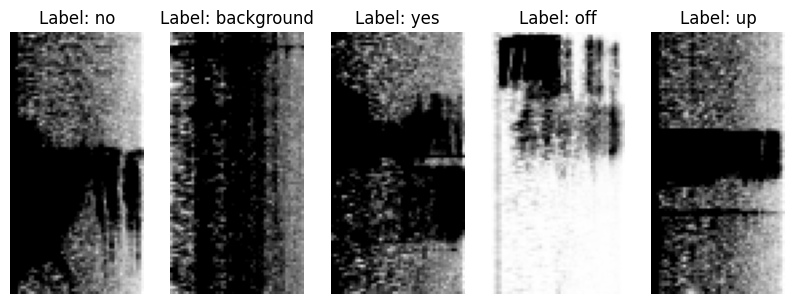

In [15]:
import matplotlib.pyplot as plt
import random

# Plot some examples
num_examples = 5
plt.figure(figsize=(10, 5))

for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    rand_index = np.random.randint(0, x_train.shape[0])
    plt.imshow(x_train[rand_index], plt.cm.binary)
    plt.title(f"Label: {label_names[np.argmax(y_train[rand_index])]}") # np.argmax() returns the index of the maximum value in the array.
    plt.axis('off')
plt.show()

# 1.2 Spectrogram Augmentation

# 1.2.1 Frequency and time masks

In [16]:
import numpy as np

def spec_augment(spec, num_freq_masks=1, num_time_masks=1, freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):
    spec_aug = spec.copy()
    max_percentage_freq = int(freq_masking_max_percentage * spec.shape[0])
    max_percentage_time = int(time_masking_max_percentage * spec.shape[1])
    
    for _ in range(num_freq_masks):
        f = np.random.randint(0, max_percentage_freq)
        f0 = np.random.randint(0, spec.shape[0] - f)
        spec_aug[f0:f0 + f, :] = 0
    
    for _ in range(num_time_masks):
        t = np.random.randint(0, max_percentage_time)
        t0 = np.random.randint(0, spec.shape[1] - t)
        spec_aug[:, t0:t0 + t] = 0
    
    return spec_aug

In [17]:
x_train_augmented = np.array([spec_augment(spec) for spec in x_train])

print(x_train_augmented.shape)

(2001, 98, 50, 1)


In [18]:
x_train_combined1 = np.concatenate([x_train, x_train_augmented], axis=0)
y_train_combined1 = np.concatenate([y_train, y_train], axis=0)

print(x_train_combined1.shape)

(4002, 98, 50, 1)


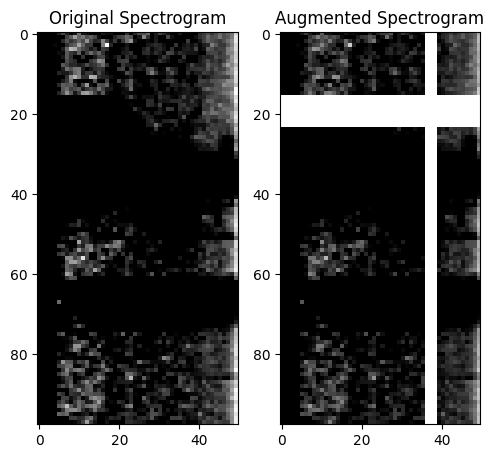

In [19]:
# Display the original spectrogram
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title('Original Spectrogram')
plt.imshow(x_train[6], plt.cm.binary)


# Display the augmented spectrogram
plt.subplot(1, 2, 2)
plt.title('Augmented Spectrogram')
plt.imshow(x_train_augmented[6], plt.cm.binary)

plt.tight_layout()
plt.show()

# 1.2.2 Spectograms mixing

In [9]:
def mixup(original_melspecs, original_labels, alpha=0.5):
    indices = np.random.permutation(original_melspecs.shape[0])

    lam = np.random.beta(alpha, alpha)

    augmented_melspecs = original_melspecs * lam + original_melspecs[indices] * (1 - lam)
    augmented_labels = original_labels * lam + original_labels[indices] * (1 - lam)

    return augmented_melspecs, augmented_labels

In [10]:
augmented_x_train, augmented_y_train = mixup(x_train, y_train)
print(augmented_x_train.shape)

(2001, 98, 50, 1)


In [11]:
x_train_combined2 = np.concatenate([x_train_combined1, augmented_x_train], axis=0)
y_train_combined2 = np.concatenate([y_train_combined1, augmented_y_train], axis=0)

print(x_train_combined2.shape)
print(y_train_combined2.shape)

(6003, 98, 50, 1)
(6003, 12)


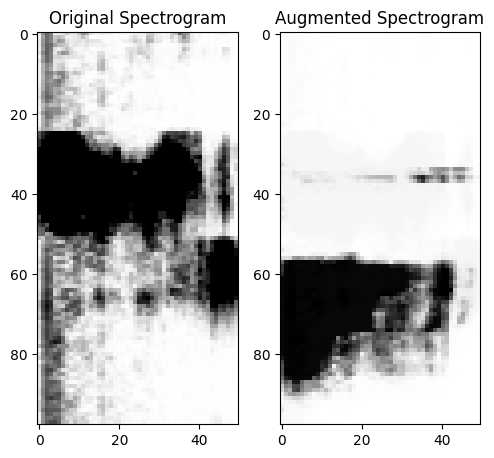

In [12]:
# Display the original spectrogram
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title('Original Spectrogram')
plt.imshow(x_train[3], plt.cm.binary)


# Display the augmented spectrogram
plt.subplot(1, 2, 2)
plt.title('Augmented Spectrogram')
plt.imshow(augmented_x_train[3], plt.cm.binary)

plt.tight_layout()
plt.show()

In [13]:
x_train_combined3 = np.concatenate([x_train, augmented_x_train], axis=0)
y_train_combined3 = np.concatenate([y_train, augmented_y_train], axis=0)

print(x_train_combined3.shape)
print(y_train_combined3.shape)

(4002, 98, 50, 1)
(4002, 12)


# 2 Main Model (Basic):

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Softmax, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2  # Import l2 regularizer

def create_model(num_layers=4, filters=(32, 64, 128), dropout_rate=0.25, learning_rate=0.001, weight_decay=0.001):
    model = Sequential()

    model.add(Conv2D(filters[0], kernel_size=(3, 3), padding='same', input_shape=(98, 50, 1), kernel_regularizer=l2(weight_decay)))  # Add L2 to kernel
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    for i in range(num_layers-1):
        model.add(Conv2D(filters[1], kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # Add L2 to all convolutional layers
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Conv2D(filters[2], kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # Add L2 to the last convolutional layer
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size =(12, 1), strides=(1, 1), padding = 'same'))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    model.add(Dense(12))  # No regularization typically applied to Dense layers
    model.add(Softmax())

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# 2.1 Training using x_train data

In [14]:
model_1 = create_model(num_layers=2, filters=(8, 16, 32), dropout_rate=0, weight_decay=0)

# Train the model
model_1.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = model_1.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15


/Users/ameeralwadiya/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-21 16:50:39.921897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.0935 - loss: 11.6940 - val_accuracy: 0.1738 - val_loss: 11.8735
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1775 - loss: 5.0811 - val_accuracy: 0.2607 - val_loss: 4.3143
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3390 - loss: 2.4392 - val_accuracy: 0.2917 - val_loss: 3.8537
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4859 - loss: 1.6448 - val_accuracy: 0.3986 - val_loss: 2.5942
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5891 - loss: 1.2990 - val_accuracy: 0.4545 - val_loss: 1.9904
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6173 - loss: 1.1616 - val_accuracy: 0.4875 - val_loss: 1.7885
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7063 - loss: 0.9568 - val_accuracy: 0.4885 - val_loss: 1.6384
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7593 - loss: 0.7804 - val_accuracy: 0.5744 - val_loss:

# 2.2 Training using x_train_combined1 data

In [15]:
model_2 = create_model(num_layers=2, filters=(8, 16, 32), dropout_rate=0, weight_decay=0)

# Train the model
model_2.fit(x_train_combined1, y_train_combined1, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = model_2.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2064 - loss: 8.5800 - val_accuracy: 0.2249 - val_loss: 7.2612
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3941 - loss: 1.8505 - val_accuracy: 0.2574 - val_loss: 4.7506
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5395 - loss: 1.4457 - val_accuracy: 0.3968 - val_loss: 2.4773
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6157 - loss: 1.2072 - val_accuracy: 0.4948 - val_loss: 1.8496
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7062 - loss: 0.9240 - val_accuracy: 0.4958 - val_loss: 1.8573
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7554 - loss: 0.7588 - val_accuracy: 0.5612 - val_loss: 1.6541
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8007 - loss: 0.6294 - val_accuracy: 0.5822 - val_loss: 1.5589
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8313 - loss: 0.5189 - val_accuracy: 0.6212 - v

# 2.3 Training using x_train_combined2 data

In [16]:
model_3 = create_model(num_layers=2, filters=(8, 16, 32), dropout_rate=0, weight_decay=0)

# Train the model
model_3.fit(x_train_combined2, y_train_combined2, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = model_3.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.1897 - loss: 7.8664 - val_accuracy: 0.2522 - val_loss: 4.9149
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4626 - loss: 1.7238 - val_accuracy: 0.3574 - val_loss: 2.8842
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6057 - loss: 1.2087 - val_accuracy: 0.5513 - val_loss: 1.8004
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6876 - loss: 0.9762 - val_accuracy: 0.6306 - val_loss: 1.6190
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7380 - loss: 0.8128 - val_accuracy: 0.6809 - val_loss: 1.4963
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7931 - loss: 0.6381 - val_accuracy: 0.7755 - val_loss: 1.2683
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8423 - loss: 0.4951 - val_accuracy: 0.7015 - val_loss: 1.5243
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8827 - loss: 0.3883 - val_accuracy: 0.8414 - v

# 2.4 Training using x_train_combined3 data

In [19]:
model_4 = create_model(num_layers=2, filters=(8, 16, 32), dropout_rate=0, weight_decay=0)

# Train the model
model_4.fit(x_train_combined3, y_train_combined3, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = model_4.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.1651 - loss: 8.7263 - val_accuracy: 0.2339 - val_loss: 3.4790
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4041 - loss: 1.9443 - val_accuracy: 0.4078 - val_loss: 2.3960
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5524 - loss: 1.3559 - val_accuracy: 0.5082 - val_loss: 1.8451
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6456 - loss: 1.0892 - val_accuracy: 0.5607 - val_loss: 1.7780
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6994 - loss: 0.9773 - val_accuracy: 0.6742 - val_loss: 1.5819
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7854 - loss: 0.7097 - val_accuracy: 0.6587 - val_loss: 1.6070
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8100 - loss: 0.6041 - val_accuracy: 0.6822 - val_loss: 1.6524
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8374 - loss: 0.4796 - val_accuracy: 0.7266 - 

- We can observe that model_2 produces the best results when trained with the combined x_train data, along with frequency and time masking, yielding an accuracy of 0.662. This suggests that combining spectogram data with x_train data, and frequency and time masking, may not be effective, as it leads to slightly less accurate results, around 0.625. Combining x_train with spectogram-mixed data might not be advisable, as evidenced by the accuracy outcome of 0.607 for x_train_combined3. This indicates that mixing spectogram data when combined results in lower accuracy. Therefore, we may exclude them from our upcoming training and testing processes.

# 3 Grid Search Optimizatiom

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=5,
                        verbose=1, num_layers=2,
                        filters=(8, 16, 32))

# Define the grid search parameters
param_grid = {
    'num_layers': [2, 3, 4, 6, 8],
    'filters': [(8, 16, 32), (16, 32, 64), (32, 64, 128), (64, 128, 256), (128, 256, 512)],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train, batch_size=32, epochs=15, validation_split=0.3)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

- The results of Grid Search Optimizatiom have been copied from Google Colab with the same configurations, as it took for ever using my processor and Jupyter notebook to implement.
- This is the last page of the training process since it contains a huge number of pages.

Epoch 1/15
44/44 [==============================] - 5s 39ms/step - loss: 3.1232 - accuracy: 0.2807 - val_loss: 10.5849 - val_accuracy: 0.1614
Epoch 2/15
44/44 [==============================] - 1s 19ms/step - loss: 2.1057 - accuracy: 0.4607 - val_loss: 2.8025 - val_accuracy: 0.3760
Epoch 3/15
44/44 [==============================] - 1s 19ms/step - loss: 1.4567 - accuracy: 0.6086 - val_loss: 1.6601 - val_accuracy: 0.5724
Epoch 4/15
44/44 [==============================] - 1s 20ms/step - loss: 1.0866 - accuracy: 0.7386 - val_loss: 2.1801 - val_accuracy: 0.4659
Epoch 5/15
44/44 [==============================] - 1s 17ms/step - loss: 0.9935 - accuracy: 0.7636 - val_loss: 1.1725 - val_accuracy: 0.7255
Epoch 6/15
44/44 [==============================] - 1s 17ms/step - loss: 0.8360 - accuracy: 0.8107 - val_loss: 1.2803 - val_accuracy: 0.7238
Epoch 7/15
44/44 [==============================] - 1s 17ms/step - loss: 0.6631 - accuracy: 0.8686 - val_loss: 0.9321 - val_accuracy: 0.7870
Epoch 8/15
44/44 [==============================] - 1s 16ms/step - loss: 0.5331 - accuracy: 0.9164 - val_loss: 0.9160 - val_accuracy: 0.8103
Epoch 9/15
44/44 [==============================] - 1s 16ms/step - loss: 0.4642 - accuracy: 0.9364 - val_loss: 1.1498 - val_accuracy: 0.7304
Epoch 10/15
44/44 [==============================] - 1s 17ms/step - loss: 0.4359 - accuracy: 0.9429 - val_loss: 1.0978 - val_accuracy: 0.7704
Epoch 11/15
44/44 [==============================] - 1s 15ms/step - loss: 0.3780 - accuracy: 0.9693 - val_loss: 0.8341 - val_accuracy: 0.8469
Epoch 12/15
44/44 [==============================] - 1s 17ms/step - loss: 0.3812 - accuracy: 0.9629 - val_loss: 1.2758 - val_accuracy: 0.7720
Epoch 13/15
44/44 [==============================] - 1s 16ms/step - loss: 0.3907 - accuracy: 0.9614 - val_loss: 1.0148 - val_accuracy: 0.8136
Epoch 14/15
44/44 [==============================] - 1s 17ms/step - loss: 0.4230 - accuracy: 0.9471 - val_loss: 0.9516 - val_accuracy: 0.8087
Epoch 15/15
44/44 [==============================] - 1s 17ms/step - loss: 0.3364 - accuracy: 0.9786 - val_loss: 1.0595 - val_accuracy: 0.8203

Best: 0.747126 using {'filters': (32, 64, 128), 'num_layers': 4}

0.635182 (0.014959) with: {'filters': (8, 16, 32), 'num_layers': 2}
0.657671 (0.021634) with: {'filters': (8, 16, 32), 'num_layers': 3}
0.614693 (0.037351) with: {'filters': (8, 16, 32), 'num_layers': 4}
0.462269 (0.028821) with: {'filters': (8, 16, 32), 'num_layers': 6}
0.405297 (0.051825) with: {'filters': (8, 16, 32), 'num_layers': 8}
0.646177 (0.057168) with: {'filters': (16, 32, 64), 'num_layers': 2}
0.690155 (0.053880) with: {'filters': (16, 32, 64), 'num_layers': 3}
0.677161 (0.034327) with: {'filters': (16, 32, 64), 'num_layers': 4}
0.591704 (0.036751) with: {'filters': (16, 32, 64), 'num_layers': 6}
0.525737 (0.032023) with: {'filters': (16, 32, 64), 'num_layers': 8}
0.631184 (0.033323) with: {'filters': (32, 64, 128), 'num_layers': 2}
0.714143 (0.055860) with: {'filters': (32, 64, 128), 'num_layers': 3}
0.747126 (0.051535) with: {'filters': (32, 64, 128), 'num_layers': 4}
0.619190 (0.046501) with: {'filters': (32, 64, 128), 'num_layers': 6}
0.502249 (0.078507) with: {'filters': (32, 64, 128), 'num_layers': 8}
0.597201 (0.052827) with: {'filters': (64, 128, 256), 'num_layers': 2}
0.655672 (0.063399) with: {'filters': (64, 128, 256), 'num_layers': 3}
0.682159 (0.120408) with: {'filters': (64, 128, 256), 'num_layers': 4}
0.704648 (0.029910) with: {'filters': (64, 128, 256), 'num_layers': 6}
0.432284 (0.159571) with: {'filters': (64, 128, 256), 'num_layers': 8}
0.562219 (0.072255) with: {'filters': (128, 256, 512), 'num_layers': 2}
0.731634 (0.036231) with: {'filters': (128, 256, 512), 'num_layers': 3}
0.636182 (0.067387) with: {'filters': (128, 256, 512), 'num_layers': 4}
0.566717 (0.018033) with: {'filters': (128, 256, 512), 'num_layers': 6}
0.570215 (0.050194) with: {'filters': (128, 256, 512), 'num_layers': 8}

# 3.1 Training using x_train data

In [15]:
grid_model_1 = create_model(num_layers=4, filters=(32, 64, 128), dropout_rate=0.25, weight_decay=0.001)

# Train the model
grid_model_1.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = grid_model_1.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

/Users/ameeralwadiya/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15


2024-03-22 08:31:34.774479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.1838 - loss: 4.9166 - val_accuracy: 0.1918 - val_loss: 5.6764
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3766 - loss: 2.3889 - val_accuracy: 0.2537 - val_loss: 5.5629
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.4633 - loss: 1.9349 - val_accuracy: 0.2208 - val_loss: 5.3796
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5586 - loss: 1.5472 - val_accuracy: 0.2887 - val_loss: 3.0722
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6629 - loss: 1.2993 - val_accuracy: 0.4166 - val_loss: 2.3111
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7413 - loss: 1.0202 - val_accuracy: 0.5365 - val_loss: 1.6896
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8339 - loss: 0.7666 - val_accuracy: 0.4755 - val_loss: 1.9784
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8161 - loss: 0.7756 - val_accuracy: 0.5894 - val_

# 3.2 Training using x_train_combined1 data


In [18]:
grid_model_2 = create_model(num_layers=4, filters=(32, 64, 128), dropout_rate=0.25, weight_decay=0.001)

# Train the model
grid_model_2.fit(x_train_combined1, y_train_combined1, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = grid_model_2.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.2282 - loss: 3.7830 - val_accuracy: 0.1994 - val_loss: 6.7382
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5065 - loss: 1.8665 - val_accuracy: 0.3193 - val_loss: 4.4979
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.6345 - loss: 1.3717 - val_accuracy: 0.4388 - val_loss: 2.6423
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7225 - loss: 1.0688 - val_accuracy: 0.5377 - val_loss: 1.8835
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7631 - loss: 0.9958 - val_accuracy: 0.6287 - val_loss: 1.5896
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.8162 - loss: 0.8105 - val_accuracy: 0.5677 - val_loss: 2.3098
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8218 - loss: 0.7684 - val_accuracy: 0.4918 - val_loss: 2.1052
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.8583 - loss: 0.6611 - val_accuracy: 0

- Both models grid_model_1 (Test Accuracy: 0.568) and grid_model_2 (Test Accuracy: 0.690) produce higher accuracies than the previous basic models model_1 (Test Accuracy: 0.547) and model_2 (Test Accuracy: 0.662).

# 4 Bayesian Optimization (Tree-structured Parzen Estimator TPE)

In [ ]:
!pip install hyperopt

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp
# fmin: Stands for "Function Minimization".
# tpe: Stands for "Tree-structured Parzen Estimator".
# hp: Stands for "Hyperparameters".

# Define the search space
space = {
    'num_layers': hp.choice('num_layers', [2, 3, 4, 6, 8]),
    'filters': hp.choice('filters', [(8, 16, 32), (16, 32, 64), (32, 64, 128), (64, 128, 256), (128, 256, 512)]),

    'dropout_rate': hp.choice('dropout_rate', [0.0, 0.1, 0.15, 0.2, 0.25]),
    'weight_decay': hp.choice('weight_decay', [0.0, 0.1, 0.01, 0.001, 0.0001]),
}

# Define the objective function
def objective(params):
    model = create_model(**params)  # Create model with current parameters

    # Train the model and evaluate on the test set
    model.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.5)
    loss, accuracy = model.evaluate(x_val, y_val)
    return {'loss': -accuracy, 'status': 'ok'}

# Run the optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

print("Best parameters found:")
print(best)

- This is the last page of the training process since it contains a huge number of pages.

 1/37 ━━━━━━━━━━━━━━━━━━━━ 22s 630ms/step - accuracy: 0.4688 - loss: 2.1764
 2/37 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.4609 - loss: 2.1940 
 3/37 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.4497 - loss: 2.1858
 4/37 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.4505 - loss: 2.1654
 5/37 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.4567 - loss: 2.1245
 6/37 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4595 - loss: 2.0960
 8/37 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4649 - loss: 2.0637 
 9/37 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4657 - loss: 2.0619
11/37 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4671 - loss: 2.0646
12/37 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.4683 - loss: 2.0611
13/37 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.4691 - loss: 2.0600
14/37 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4692 - loss: 2.0587
15/37 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4689 - loss: 2.0605
17/37 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4685 - loss: 2.0631
18/37 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4682 - loss: 2.0634
19/37 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4680 - loss: 2.0621
21/37 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4672 - loss: 2.0616
23/37 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4668 - loss: 2.0613
25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4664 - loss: 2.0603
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4660 - loss: 2.0599
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4657 - loss: 2.0615
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4657 - loss: 2.0615
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4661 - loss: 2.0596
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4661 - loss: 2.0589
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4662 - loss: 2.0583
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4664 - loss: 2.0573
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.4665 - loss: 2.0564

100%|████████| 20/20 [32:15<00:00, 96.77s/trial, best loss: -0.6379163265228271]

Best parameters found:
{'dropout_rate': 3, 'filters': 2, 'num_layers': 1, 'weight_decay': 3}

# 4.1 Training using x_train data


In [19]:
bayesian_model_1 = create_model(num_layers=3, filters=(32, 64, 128), dropout_rate=0.2, weight_decay=0.001)

# Train the model
bayesian_model_1.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = bayesian_model_1.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.1408 - loss: 12.0186 - val_accuracy: 0.0779 - val_loss: 24.8707
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.1698 - loss: 5.1703 - val_accuracy: 0.0979 - val_loss: 19.5419
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.2856 - loss: 2.8379 - val_accuracy: 0.1129 - val_loss: 11.0873
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.3841 - loss: 2.1310 - val_accuracy: 0.1988 - val_loss: 6.7337
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5133 - loss: 1.7027 - val_accuracy: 0.2248 - val_loss: 4.8883
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5005 - loss: 1.6239 - val_accuracy: 0.3347 - val_loss: 3.6158
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6233 - loss: 1.4131 - val_accuracy: 0.4296 - val_loss: 2.3082
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7025 - loss: 1.0841 - val_accuracy

# 4.2 Training using x_train_combined1 data

In [20]:
bayesian_model_2 = create_model(num_layers=3, filters=(32, 64, 128), dropout_rate=0.2, weight_decay=0.001)

# Train the model
bayesian_model_2.fit(x_train_combined1, y_train_combined1, batch_size=64, epochs=15, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = bayesian_model_2.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.1746 - loss: 10.9249 - val_accuracy: 0.1159 - val_loss: 13.7582
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.3010 - loss: 2.6013 - val_accuracy: 0.2729 - val_loss: 7.6634
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5077 - loss: 1.6962 - val_accuracy: 0.4308 - val_loss: 2.7333
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5620 - loss: 1.5292 - val_accuracy: 0.4498 - val_loss: 2.5468
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6886 - loss: 1.1236 - val_accuracy: 0.3798 - val_loss: 3.0064
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7319 - loss: 0.9988 - val_accuracy: 0.5087 - val_loss: 2.5325
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7766 - loss: 0.9284 - val_accuracy: 0.4858 - val_loss: 2.6183
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8321 - loss: 0.6967 - val_accuracy:

- The first model bayesian_model_1 (Test Accuracy: 0.593) produce higher accuracy than grid_model_1 (Test Accuracy: 0.568) and bayesian_model_2 (Test Accuracy: 0.722) produce higher accuracy than the previous model  grid_model_2 (Test Accuracy: 0.690).

# 5 Monitoring Training Progress:

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9512 - loss: 0.2692 - val_accuracy: 0.7326 - val_loss: 2.1422
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9851 - loss: 0.1469 - val_accuracy: 0.8356 - val_loss: 1.1630
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9806 - loss: 0.1523 - val_accuracy: 0.8496 - val_loss: 0.9431
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9863 - loss: 0.1405 - val_accuracy: 0.9235 - val_loss: 0.4846
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9917 - loss: 0.1176 - val_accuracy: 0.8921 - val_loss: 0.6651
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9968 - loss: 0.1075 - val_accuracy: 0.9065 - val_loss: 0.5381
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9855 - loss: 0.1477 - val_accuracy: 0.8701 - val_loss: 0.8509
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9851 - loss: 0.1366 - val_accuracy: 0.

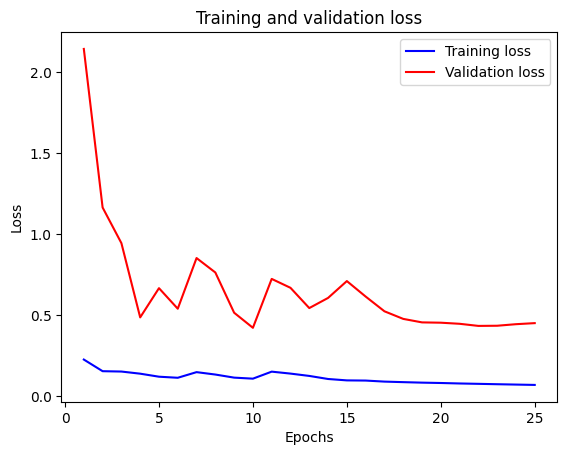

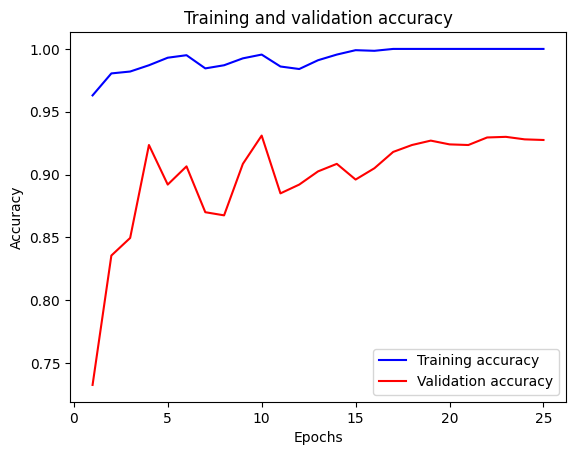

In [27]:
# Train the model
history = bayesian_model_2.fit(x_train_combined1, y_train_combined1, batch_size=64, epochs=25, validation_split=0.5)

# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
# Evaluate the model on test data
test_loss, test_accuracy = bayesian_model_2.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7626 - loss: 2.7968
Test Accuracy: 0.7719897627830505


- Training the model with the number of epochs=25, resulted in a better accuracy:

# 5.1 Confusion matrix

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


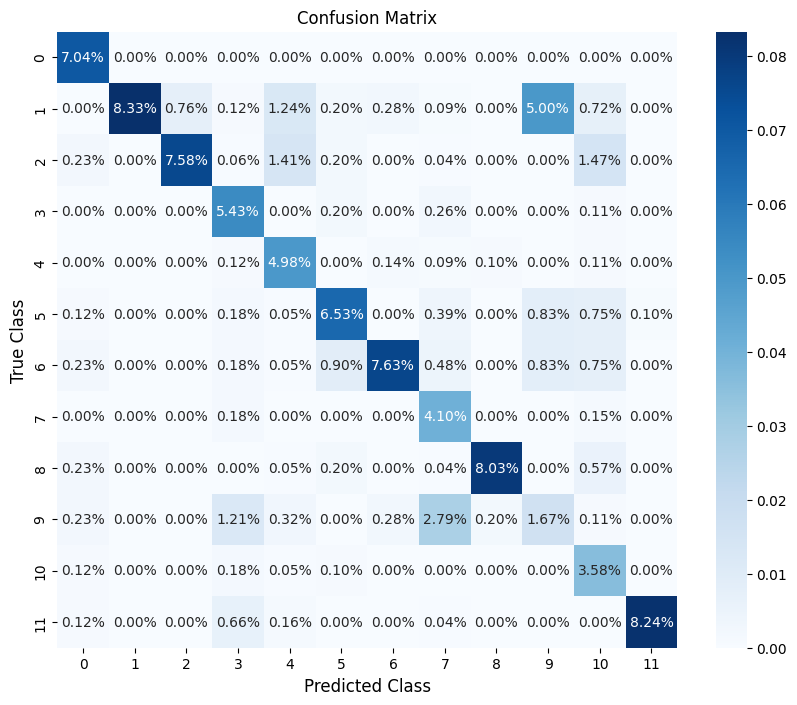

In [32]:
# obtain model predictions and convert softmax outputs 0-1 to integer class label predictions
Yhat = bayesian_model_2.predict(x_val)                 # predict model outputs on validation data as softmax outputs of probability of each class
Yhat_integer = np.argmax(Yhat, axis=1)      # obtain the most likely class prediction as the argument of the max softmax output
Y_test_integer = np.argmax(y_val, axis=1)   # obtain the true class as an integer

# calculate and plot confusion matrix
cm = confusion_matrix(Y_test_integer, Yhat_integer , normalize="pred")    # calculate the confusion matrix
plt.figure(figsize=(10, 8))  # setup new figure
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="Blues",)          # plot the confusion matrix using the sns package
plt.title("Confusion Matrix", fontsize = 12)                              # title
plt.xlabel("Predicted Class", fontsize = 12)                              # xlabel
plt.ylabel("True Class", fontsize = 12)                                   # ylabel
plt.show()    

# 6 Model Averging

In [39]:
def resample_data(x_train, y_train):
    # Define number of samples
    nsamples = int(x_train.shape[0]/2)

    # Create data index
    data_index = list(range(1, nsamples))

    # Create random index using sampling with replacement
    idx = random.choices(data_index, k=nsamples)

    # Initialize data set 1
    x1 = np.zeros([nsamples, 98, 50, 1])
    y1 = np.zeros([nsamples, 12])

    # Resample training data with replacement
    for i in range(nsamples):
        x1[i] = x_train[idx[i], :, :, :]
        y1[i] = y_train[idx[i], :]

    return x1, y1

In [42]:
num_models = 3

# Initialize list to store individual model predictions
predictions = []

# Train and make predictions for each model
for _ in range(num_models):
    # Resample the data
    x1, y1 = resample_data(x_train_combined1, y_train_combined1)
    print(x1.shape)
    # Initialize and train a model
    model = create_model(num_layers=3, filters=(32, 64, 128), dropout_rate=0.2, weight_decay=0.001)
    model.fit(x1, y1, batch_size=64, epochs=25, validation_split=0.5)
    
    test_loss, test_accuracy = model.evaluate(x_val, y_val)
    predictions.append(test_accuracy)  
    print("Test Accuracy:", test_accuracy)
    
# Calculate average prediction across all models
average_prediction = np.mean(predictions, axis=0)

(2001, 98, 50, 1)
Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 721ms/step - accuracy: 0.0969 - loss: 11.8289 - val_accuracy: 0.0879 - val_loss: 25.6012
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - accuracy: 0.1945 - loss: 5.4108 - val_accuracy: 0.0709 - val_loss: 13.9921
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.2874 - loss: 2.8050 - val_accuracy: 0.1548 - val_loss: 8.9707
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.4162 - loss: 2.0407 - val_accuracy: 0.2058 - val_loss: 5.2952
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5045 - loss: 1.8180 - val_accuracy: 0.3796 - val_loss: 3.2472
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5925 - loss: 1.4214 - val_accuracy: 0.4386 - val_loss: 2.3861
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7183 - loss: 1.1133 - val_accuracy: 0.5295 - val_loss: 1.8504
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7554 - loss: 0.9

In [44]:
print(average_prediction)

0.6387703021367391


# 7 Multi-Branch Networks (Inception)

![](https://d2l.ai/_images/inception.svg)

In [10]:
class Inception(tf.keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = Conv2D(c1, 1, activation='relu')
        
        self.b2_1 = Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = Conv2D(c2[1], 3, padding='same', activation='relu')
        
        self.b3_1 = Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = Conv2D(c3[1], 5, padding='same', activation='relu')
        
        self.b4_1 = MaxPooling2D(3, 1, padding='same')
        self.b4_2 = Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Softmax, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2  # Import l2 regularizer

def create_model_advanced(num_layers=4, filters=(32, 64, 128), dropout_rate=0.25, learning_rate=0.001, weight_decay=0.001):
    model = Sequential()

    model.add(Conv2D(filters[0], kernel_size=(3, 3), padding='same', input_shape=(98, 50, 1), kernel_regularizer=l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    for i in range(num_layers-1):
        if i == num_layers - 2:  # Last iteration, add Inception layers
            model.add(Inception(64, (96, 128), (16, 32), 32))
            model.add(Inception(128, (128, 192), (32, 96), 64))
            model.add(Inception(192, (96, 208), (16, 48), 64))
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
        else:
            model.add(Conv2D(filters[1], kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Conv2D(filters[2], kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size =(12, 1), strides=(1, 1), padding = 'same'))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    model.add(Dense(12))  
    model.add(Softmax())

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [86]:
inception_model = create_model_advanced(num_layers=3, filters=(32, 64, 128), dropout_rate=0.2, weight_decay=0.001)

# Train the model
inception_model.fit(x_train_combined1, y_train_combined1, batch_size=64, epochs=25, validation_split=0.5)

# Evaluate the model on test data
test_loss, test_accuracy = inception_model.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.1693 - loss: 7.7283 - val_accuracy: 0.1594 - val_loss: 19.6459
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2599 - loss: 2.7665 - val_accuracy: 0.2149 - val_loss: 6.7911
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3979 - loss: 2.0853 - val_accuracy: 0.3773 - val_loss: 2.7803
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5469 - loss: 1.6737 - val_accuracy: 0.4058 - val_loss: 2.1485
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6533 - loss: 1.3158 - val_accuracy: 0.3418 - val_loss: 2.8857
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7175 - loss: 1.0602 - val_accuracy: 0.3633 - val_loss: 2.4955
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7950 - loss: 0.8047 - val_accuracy: 0.5257 - val_loss: 1.9178
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7937 - loss: 0.9886 - val_accuracy: 0.5627 - val_los

# 7.1 Bayesian optimization (Tree-structured Parzen Estimator TPE)

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp
# fmin: Stands for "Function Minimization".
# tpe: Stands for "Tree-structured Parzen Estimator".
# hp: Stands for "Hyperparameters".

# Define the search space
space = {
    'num_layers': hp.choice('num_layers', [2, 3, 4, 6, 8]),
    'filters': hp.choice('filters', [(8, 16, 32), (16, 32, 64), (32, 64, 128), (64, 128, 256), (128, 256, 512)]),

    'dropout_rate': hp.choice('dropout_rate', [0.0, 0.1, 0.15, 0.2, 0.25]),
    'weight_decay': hp.choice('weight_decay', [0.0, 0.1, 0.01, 0.001, 0.0001]),
}

# Define the objective function
def objective(params):
    model = create_model_advanced(**params)  # Create model with current parameters

    # Train the model and evaluate on the test set
    model.fit(x_train, y_train, batch_size=64, epochs=15, validation_split=0.5)
    loss, accuracy = model.evaluate(x_val, y_val)
    return {'loss': -accuracy, 'status': 'ok'}

# Run the optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

print("Best parameters found:")
print(best)

- This is the last page of the training process since it contains a huge number of pages.

 1/37 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.3750 - loss: 2.1478
 2/37 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.3984 - loss: 2.0991
 3/37 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.4149 - loss: 2.0402
 4/37 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.4206 - loss: 2.0252
 5/37 ━━━━━━━━━━━━━━━━━━━━ 16s 500ms/step - accuracy: 0.4302 - loss: 1.9947
 6/37 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.4366 - loss: 1.9628
 7/37 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.4438 - loss: 1.9308
 8/37 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.4488 - loss: 1.9065 
 9/37 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.4530 - loss: 1.8866
10/37 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.4568 - loss: 1.8709
11/37 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.4602 - loss: 1.8568
12/37 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.4628 - loss: 1.8435
13/37 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.4648 - loss: 1.8331
14/37 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.4662 - loss: 1.8264
15/37 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.4679 - loss: 1.8195
16/37 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.4691 - loss: 1.8143
17/37 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.4699 - loss: 1.8115
18/37 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.4709 - loss: 1.8077
19/37 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.4722 - loss: 1.8033
20/37 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.4734 - loss: 1.7994
21/37 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.4746 - loss: 1.7953
22/37 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.4754 - loss: 1.7924
23/37 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4764 - loss: 1.7895
24/37 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.4774 - loss: 1.7870
25/37 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4785 - loss: 1.7841
26/37 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.4796 - loss: 1.7814
27/37 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.4806 - loss: 1.7790
28/37 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.4813 - loss: 1.7778
29/37 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.4820 - loss: 1.7764
30/37 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.4829 - loss: 1.7746
31/37 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.4837 - loss: 1.7730
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4843 - loss: 1.7718
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4850 - loss: 1.7705
34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4856 - loss: 1.7691
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.4862 - loss: 1.7678
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.4868 - loss: 1.7661
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.4875 - loss: 1.7643
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 265ms/step - accuracy: 0.4882 - loss: 1.7626

100%|█████| 20/20 [3:14:46<00:00, 584.32s/trial, best loss: -0.5123825669288635]

Best parameters found:
{'dropout_rate': 2, 'filters': 3, 'num_layers': 4, 'weight_decay': 4}

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
optimized_inception_model.fit(x_train_combined1, y_train_combined1, 
                              batch_size=16, 
                              epochs=25, 
                              validation_split=0.5, 
                              callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = optimized_inception_model.evaluate(x_val, y_val)
print("Test Accuracy:", test_accuracy)

Epoch 1/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 610ms/step - accuracy: 0.8480 - loss: 0.5801 - val_accuracy: 0.5237 - val_loss: 2.0781
Epoch 2/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 70s 555ms/step - accuracy: 0.8401 - loss: 0.5600 - val_accuracy: 0.4043 - val_loss: 3.7787
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - accuracy: 0.8680 - loss: 0.5070 - val_accuracy: 0.6022 - val_loss: 1.8488
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.8894 - loss: 0.4744 - val_accuracy: 0.6752 - val_loss: 1.0719
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 535ms/step - accuracy: 0.9093 - loss: 0.3654 - val_accuracy: 0.5982 - val_loss: 1.4757
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - accuracy: 0.8838 - loss: 0.4700 - val_accuracy: 0.7091 - val_loss: 1.2145
Epoch 7/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 500ms/step - accuracy: 0.9271 - loss: 0.3493 - val_accuracy: 0.6857 - val_loss: 1.5653
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5857 - loss: 1.5854
Test Accu

- With this advanced model, the results are not as expected. I anticipated achieving higher accuracy, especially since I implemented an inception class, which includes using parallel convolutional layers. These layers are supposed to aid in extracting more features from the data, thereby increasing accuracy. However, it appears that there are other factors at play that could contribute to improving accuracy for this model, such as employing more advanced optimization algorithms.

- The highest accuracy has been extracted from Bayesian_model_2 (in section 5), as it achieves a 77% accuracy in predicting true spectrograms.